### Step 1 — Load Required Libraries

We import requests for API calls and pandas/numpy for time-series cleaning.
This notebook focuses on retrieving daily temperature and HDD estimates from NOAA so we can use them as ML features.

In [45]:
# Robust NOAA daily fetch (GHCND) with retries/backoff + per-year pagination
import requests, pandas as pd, time, datetime as dt
from requests.adapters import HTTPAdapter, Retry

### Step 2 — NOAA Weather API (Daily Temperature)

We use the NOAA “Daily Global Surface Summary of Day” (GSOD) dataset.
	•	Coverage: 2010 → Today
	•	Frequency: Daily
	•	Variables we fetch:
	•	TAVG – Average daily temperature (°C)
	•	TMAX – Max temperature
	•	TMIN – Min temperature

For energy models, TAVG is the main input.
We also compute a Heating Degree Days (HDD) estimate:

HDD = max(0, 18°C − TAVG)
(US industry standard for gas-demand weather sensitivity)


In [46]:
NOAA_TOKEN = "hwTmlrZowehymzlfbevTAFFOsKujEseL"
STATION_ID = "GHCND:USW00003952"   # Dallas Love Field
START_DATE = "2010-01-01"
END_DATE   = dt.date.today().isoformat()

RAW_CSV = "weather_raw_dallas_daily.csv"
BIZ_CSV = "weather_biz_dallas_daily.csv"

def _session_with_retry(total=6, backoff=1.5):
    retries = Retry(
        total=total,
        read=total,
        connect=total,
        backoff_factor=backoff,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"]
    )
    s = requests.Session()
    s.headers.update({"token": NOAA_TOKEN})
    s.mount("https://", HTTPAdapter(max_retries=retries))
    s.mount("http://", HTTPAdapter(max_retries=retries))
    return s

### Step 3 — Fetch NOAA Daily Weather (Temperature)

NOAA returns up to 1 year per request → we loop year-by-year.

In [47]:
def fetch_noaa_daily(station_id=STATION_ID, start=START_DATE, end=END_DATE, year_timeout=60):
    s = _session_with_retry()
    start_year, end_year = int(start[:4]), int(end[:4])
    all_rows = []

    for yr in range(start_year, end_year + 1):
        yr_start = f"{yr}-01-01" if yr > start_year else start
        yr_end   = f"{yr}-12-31" if yr < end_year   else end
        print(f"Year {yr} … ", end="", flush=True)

        offset, limit = 1, 1000
        got_any, last_count = False, -1

        while True:
            params = {
                "datasetid": "GHCND",
                "stationid": station_id,
                "datatypeid": ["TMAX", "TMIN", "TAVG"],
                "startdate": yr_start,
                "enddate": yr_end,
                "units": "metric",
                "limit": limit,
                "offset": offset,
            }
            try:
                r = s.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data",
                          params=params, timeout=year_timeout)
            except requests.exceptions.ReadTimeout:
                # Big pages sometimes stall — nudge and continue
                print(" (timeout→retry)", end="", flush=True)
                time.sleep(2)
                continue

            if r.status_code == 400 and "token" in r.text.lower():
                raise RuntimeError("NOAA token looks invalid. Regenerate at https://www.ncdc.noaa.gov/cdo-web/token")
            if r.status_code != 200:
                # Soft-fail this page/year but continue overall
                print(f"\n  WARN {r.status_code}: {r.text.strip()[:160]}")
                break

            payload = r.json()
            rows = payload.get("results", [])
            if not rows:
                break

            all_rows.extend(rows)
            got_any = True

            # Update offset; also read metadata to decide when to stop
            meta = payload.get("metadata", {}).get("resultset", {})
            count = meta.get("count", None)
            offset += limit

            # Guard: if count isn’t provided or we’re not making progress, bail
            if count is None:
                # rely on empty-rows break above next loop
                pass
            else:
                if last_count == count:
                    # no progress—avoid infinite loop
                    break
                last_count = count
                if offset > int(count):
                    break

        print("done." if got_any else "empty.")

        # Optional: checkpoint each year (append mode)
        # Turn what we have into a dataframe and write/append per-year if you want durability.

    if not all_rows:
        return pd.DataFrame(columns=["date","temp_c","temp_max_c","temp_min_c"])

    df = pd.DataFrame(all_rows)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    wide = df.pivot_table(index="date", columns="datatype", values="value", aggfunc="mean").reset_index()

    # Compute TAVG if missing
    if "TAVG" not in wide.columns or wide["TAVG"].isna().all():
        wide["TAVG"] = (wide.get("TMAX") + wide.get("TMIN")) / 2.0

    wide = wide.rename(columns={"date":"date", "TAVG":"temp_c", "TMAX":"temp_max_c", "TMIN":"temp_min_c"})
    wide = wide[["date","temp_c","temp_max_c","temp_min_c"]].sort_values("date").reset_index(drop=True)
    wide["date"] = pd.to_datetime(wide["date"])
    return wide

### Step 4 — Run Fetch + Save

In [49]:
# Run + save
raw = fetch_noaa_daily()
raw.to_csv(RAW_CSV, index=False)
print("Saved:", RAW_CSV, "| shape:", raw.shape)

# Business-day fill
bd = pd.DataFrame({"date": pd.bdate_range(raw.date.min(), raw.date.max())})
wx_biz = bd.merge(raw, on="date", how="left").ffill()
wx_biz.to_csv(BIZ_CSV, index=False)
print("Saved:", BIZ_CSV, "| shape:", wx_biz.shape)

Year 2010 … done.
Year 2011 … done.
Year 2012 … done.
Year 2013 … done.
Year 2014 … done.
Year 2015 … done.
Year 2016 … done.
Year 2017 … done.
Year 2018 … done.
Year 2019 … done.
Year 2020 … done.
Year 2021 … done.
Year 2022 … done.
Year 2023 … done.
Year 2024 … done.
Year 2025 … done.
Saved: weather_raw_dallas_daily.csv | shape: (5819, 4)
Saved: weather_biz_dallas_daily.csv | shape: (4156, 4)


### Step 5 — Quick Visual Check

<Axes: xlabel='date'>

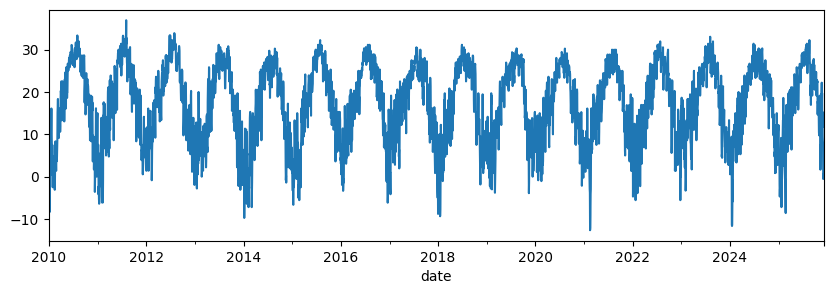

In [50]:
wx_biz.set_index("date")["temp_c"].plot(figsize=(10,3))